# Analiza szeregu czasowego

Analizowane dane pochodzą z archiwum Banku Ochrony Środowiska S.A. i dotyczą uśrednionych kursów dolara amerykańskiego w stosunku do (USD) do polskiej złotówki (PLN), obejmują okres od 4. stycznia 1993 do 21. lutego 2020.

https://info.bossa.pl/notowania/metastock/

Plik **USD.mst.ORIGINAL** zawiera oryginalne, niezmodyfiikowane, **USD.mst** - dane wstępnie przetworzone przeze mnie poprzez kilka makr w edytorze Emacs. Aby łatwiej wczytywać i procesować ten zbiór, zostawiłem tylko dwie kolumny - daty w formacie *YYYY-MM-DD* oraz wartość dolara podczas zamknięcia danego dnia.

In [125]:
library("forecast")
library("zoo")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [60]:
usd <- read.table("USD.mst", sep = ",", header = TRUE, colClasses = c("Date", "double"))

In [61]:
usd

yyyy.mm.dd,value
<date>,<dbl>
1993-01-04,1.5777
1993-01-05,1.5888
1993-01-06,1.5912
1993-01-07,1.5864
1993-01-08,1.5904
1993-01-11,1.5992
1993-01-12,1.5917
1993-01-13,1.5891
1993-01-14,1.5938


Dane nie są zbierane codziennie - wartości kursów NBP ogłasza wyłącznie w dni robocze  (pon.-pt.), przez co liczba punktów w danym roku nie odpowiada liczbie dni. Dlatego zamiast wbudowanego w system R obiektu **TimeSeries**, który niejako narzuca odstępy pomiędzy kolejnymi pomiarami do poniższej wizualizacji wykorzystałem pakiet **zoo**.

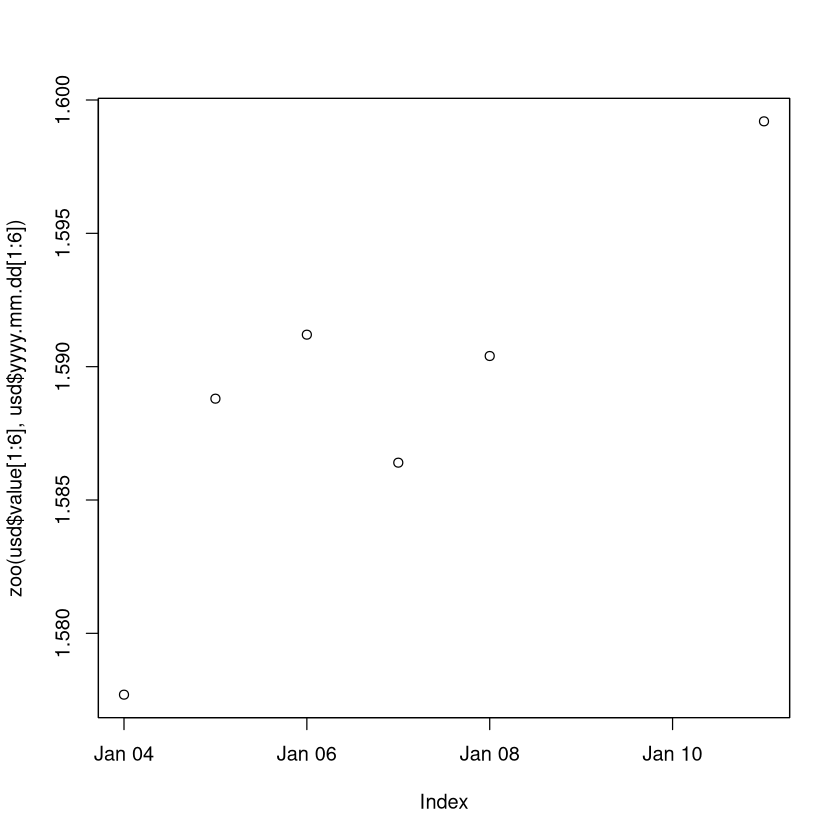

In [79]:
plot(zoo(usd$value[1:6], usd$yyyy.mm.dd[1:6]), type = 'p')

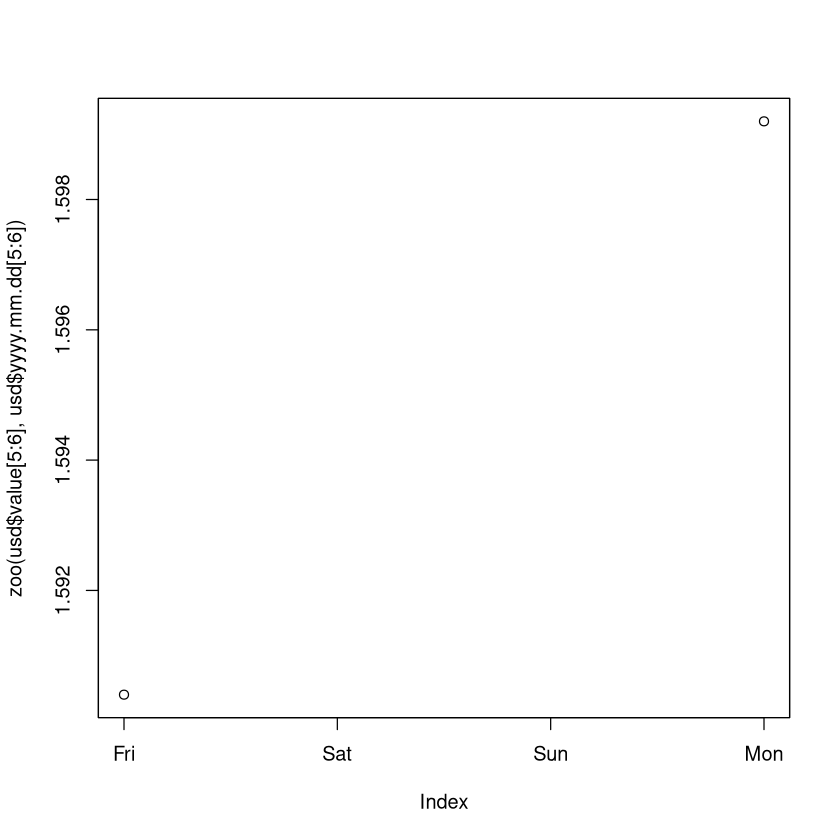

In [80]:
plot(zoo(usd$value[5:6], usd$yyyy.mm.dd[5:6]), type = 'p')

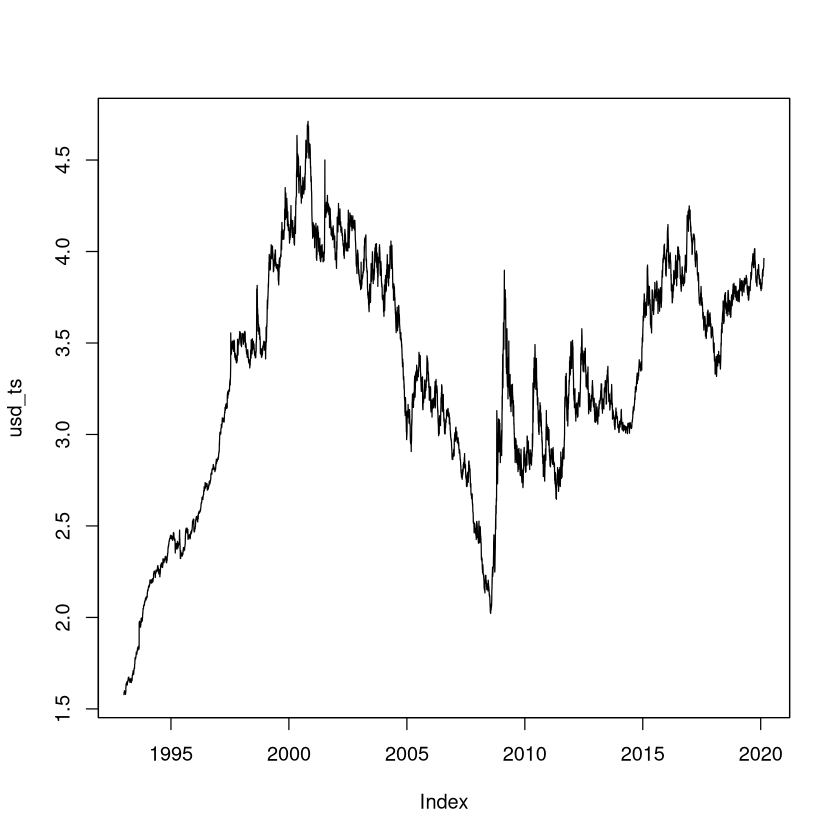

In [89]:
usd_ts <- zoo(usd$value, usd$yyyy.mm.dd)
plot(usd_ts)

In [93]:
usd_dates <- index(usd_ts)
usd_num <- as.numeric(usd_ts)

Mimo nieregularności danych, musimy przyjąć jakąś częstotliwość okresów aby rozważyć sezonowość.
Niech będzie to zatem liczba wszystkich pomiarów (poza początkiem obecnego, 2020, roku) podzielona przez liczbę lat. Od tej pory oznaczenia na osi X wykresów będą jedynie "mniej-więcej" odpowiadać rzeczywistości.

In [104]:
SEASON_DAYS <- round(6816 / 27)
SEASON_DAYS

[1] 252

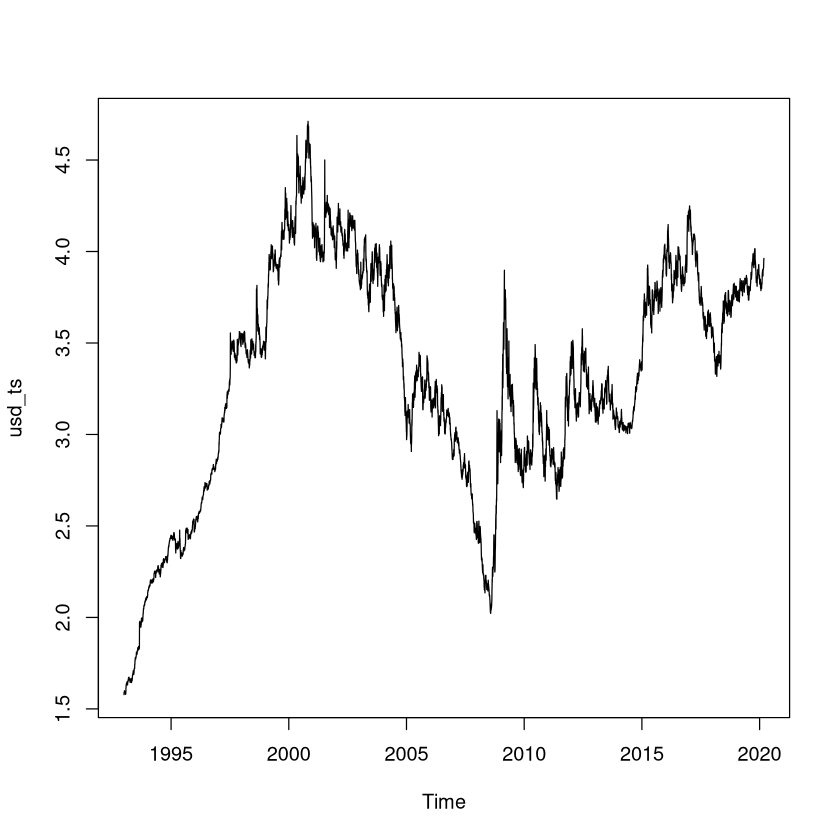

In [117]:
usd_ts <- ts(usd_num, frequency = SEASON_DAYS, start = 1993)
plot(usd_ts)

Rozkładamy szereg na 3 podstawowe komponenty: trend, sezonowość oraz zaburzenie "losowe", bądź dające się do losowego sprowadzić - co sprawdzimy za chwilę.

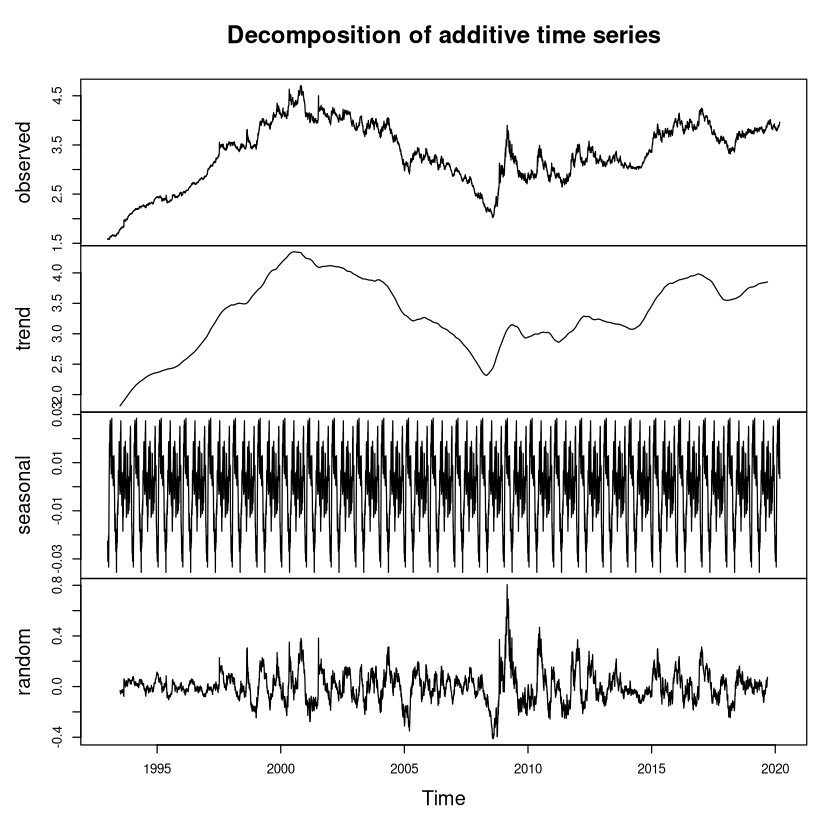

In [118]:
usd_decomposed <- decompose(usd_ts)
plot(usd_decomposed)

Jak widać, sezonowość jest raczej niewielka - amplituda między dołkiem w marcu oraz w okolicy końca/początku roku a wyżynami to około 6 groszy.

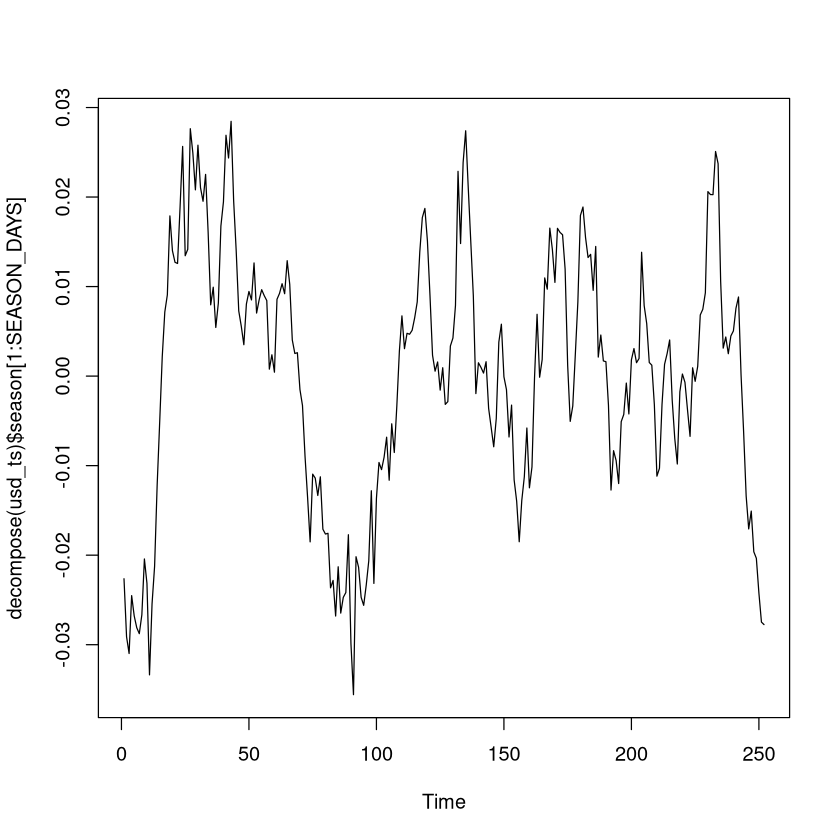

In [122]:
plot.ts(decompose(usd_ts)$season[1:SEASON_DAYS])

Dokonujemy korekty sezonowości poprzez odjęcie wyznaczonego wcześniej komponentu, po uważnym przyjrzeniu się widać, że linia wykresu w niektórych miejscach uległa wygładzeniu.

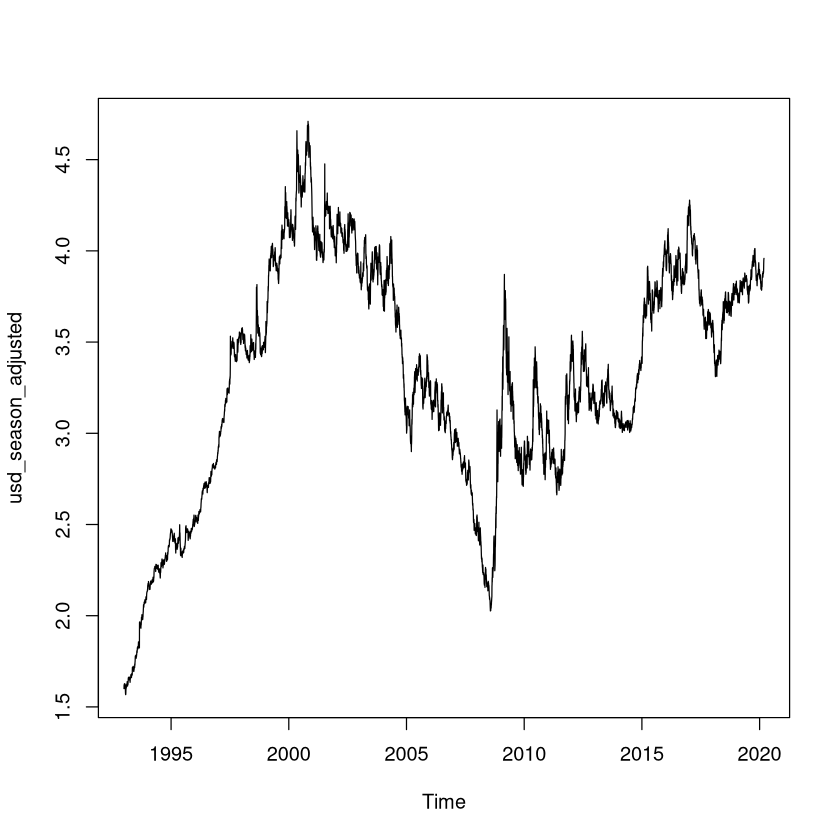

In [123]:
usd_season_adjusted <- usd_num - usd_decomposed$seasonal
plot(usd_season_adjusted)

Następnie próbujemy wyrazić ten szereg w modelu ARIMA, t.j. wyznaczyć optymalne wartości parametrów **p**, **d** oraz **q**, czyli odpowiednio liczby wyrazów rozważanych przez autoregresję, stopnia dyskretnej "pochodnej" oraz liczbie wyrazów rozważanych przez średnie kroczące.

Już przy **d = 1** uzyskany szereg jest "w miarę" stacjonarny.

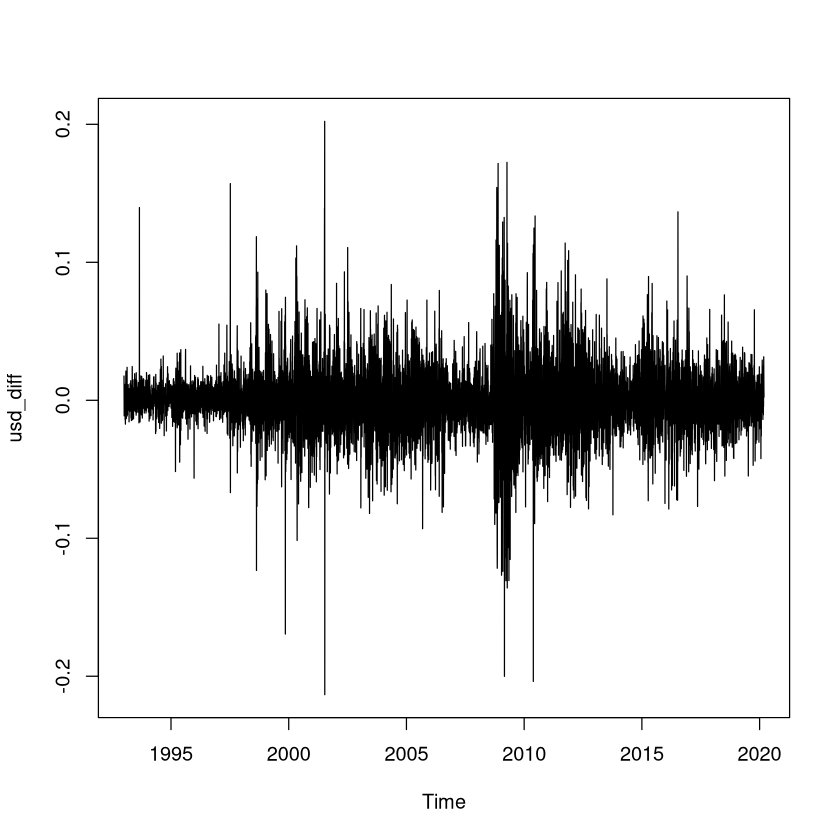

In [181]:
usd_diff <- diff(usd_season_adjusted, differences = 1)
plot(usd_diff)

Wyznaczenie reszty parametrów powierzamy systemowi R.

In [202]:
usd_fit <- auto.arima(usd_num)
usd_fit

Series: usd_num 
ARIMA(0,1,3) 

Coefficients:
          ma1     ma2      ma3
      -0.0093  0.0302  -0.0453
s.e.   0.0121  0.0122   0.0122

sigma^2 estimated as 0.0006807:  log likelihood=15260.46
AIC=-30512.92   AICc=-30512.92   BIC=-30485.59

Zaproponowane parametry to 0 wyrazów AR oraz 3 MA. Czy słusznie? Sprawdźmy!

Auto-korelogram nie wykazuje żadnych statystycznie znaczących ciągów lagów - 0 wydaje się być uzasadnione.

Uwaga: mimo oznaczeń ułamkowych, korelogramy reprezentują poprzedni tydzień.

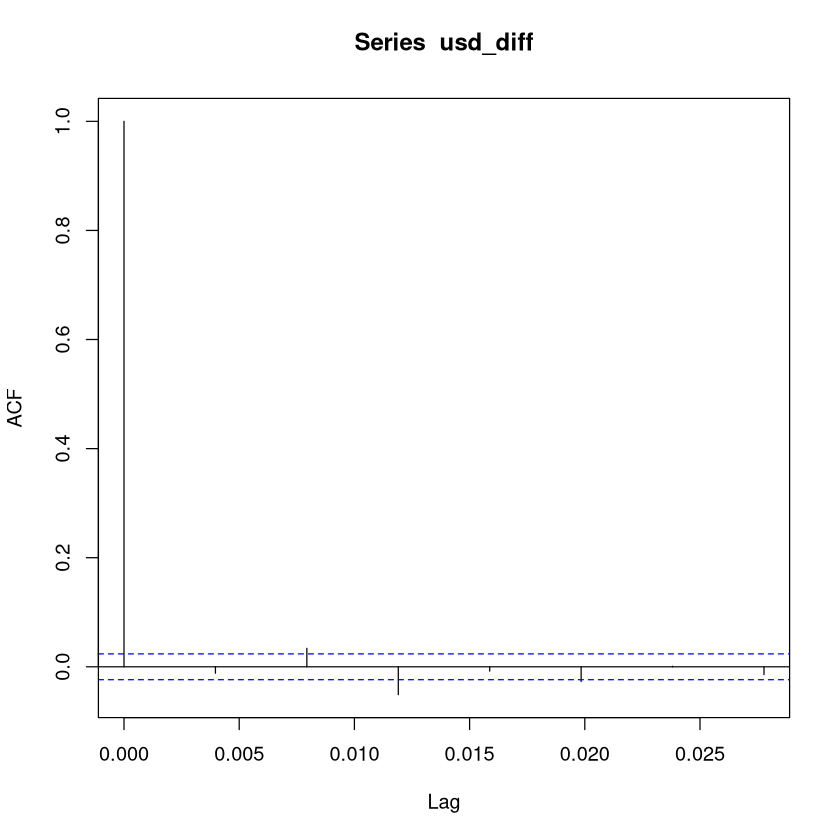

In [220]:
acf(usd_diff, lag.max = 7)  # 7 ostatnich dni

Cząstkowy(?) auto-korelogram z kolei przykuwa uwagę do lagów 2. i 3. (co ciekawe, pierwszy wygląda statystycznie nieznacząco) - trójka w modelu może zatem mieć pewien sens.

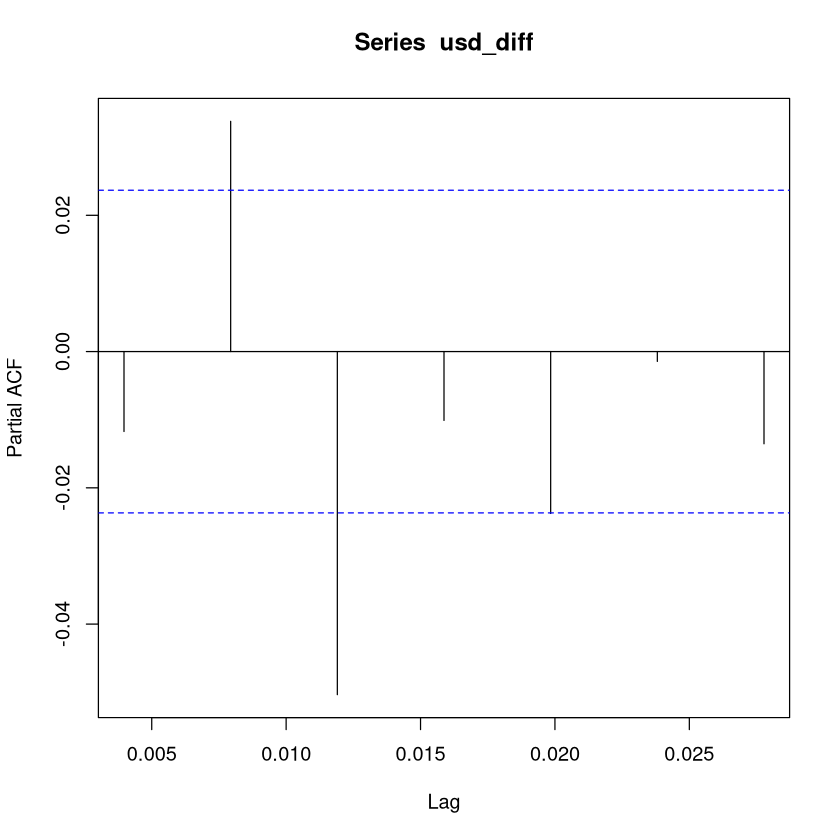

In [218]:
pacf(usd_diff, lag.max = 7)

Upewniamy się również, jak wygląda zachowanie błędów w naszym modelu.

Wysoki p-value, skupienie (wyglądającego gaussowsko) rozkładu błędów wokół zera oraz wygląd ich korelogramu sugerują że to w miarę poprawny model analizowanego szeregu.


	Ljung-Box test

data:  Residuals from ARIMA(0,1,3)
Q* = 16.644, df = 7, p-value = 0.01984

Model df: 3.   Total lags used: 10



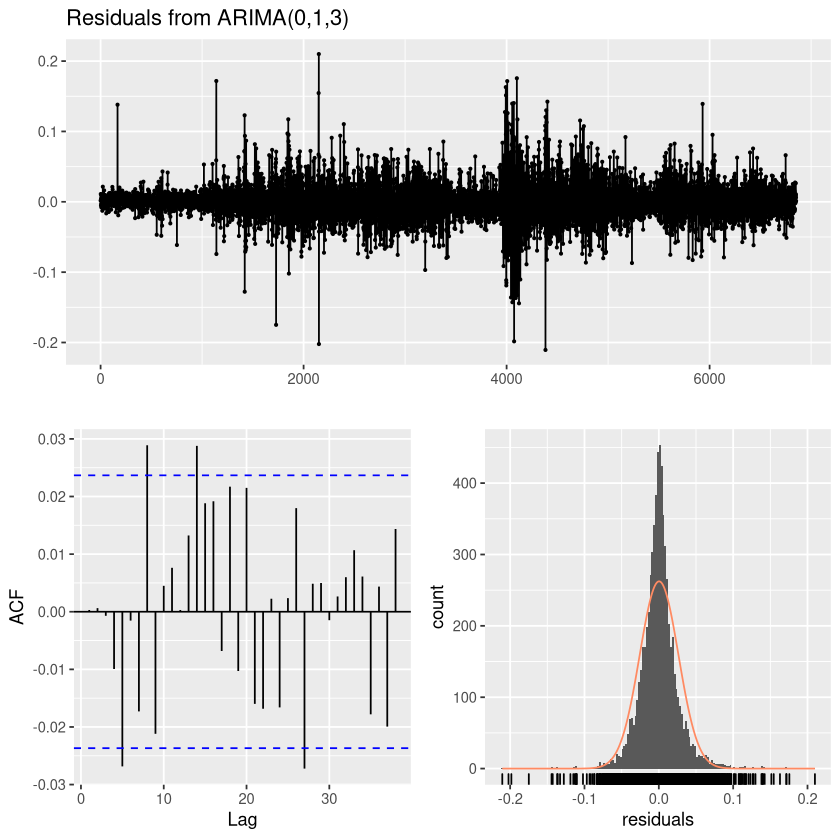

In [221]:
checkresiduals(usd_fit)

Na koniec dokonujemy prognozy na kolejne 3 lata ;]

In [231]:
usd_synopsis <- forecast(usd_fit, h = 250*3)
usd_synopsis

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
6853       3.961989 3.928553 3.995425 3.910853 4.013124
6854       3.961742 3.914675 4.008809 3.889760 4.033725
6855       3.961691 3.903549 4.019833 3.872770 4.050612
6856       3.961691 3.895023 4.028359 3.859731 4.063651
6857       3.961691 3.887470 4.035912 3.848180 4.075202
6858       3.961691 3.880618 4.042764 3.837700 4.085682
6859       3.961691 3.874301 4.049081 3.828039 4.095342
6860       3.961691 3.868411 4.054971 3.819032 4.104350
6861       3.961691 3.862872 4.060510 3.810560 4.112822
6862       3.961691 3.857627 4.065755 3.802538 4.120844
6863       3.961691 3.852634 4.070748 3.794902 4.128480
6864       3.961691 3.847859 4.075522 3.787601 4.135781
6865       3.961691 3.843278 4.080104 3.780593 4.142789
6866       3.961691 3.838866 4.084515 3.773847 4.149535
6867       3.961691 3.834608 4.088774 3.767335 4.156047
6868       3.961691 3.830488 4.092893 3.761034 4.162348
6869       3.961691 3.826494 4.096888 3.754925 4

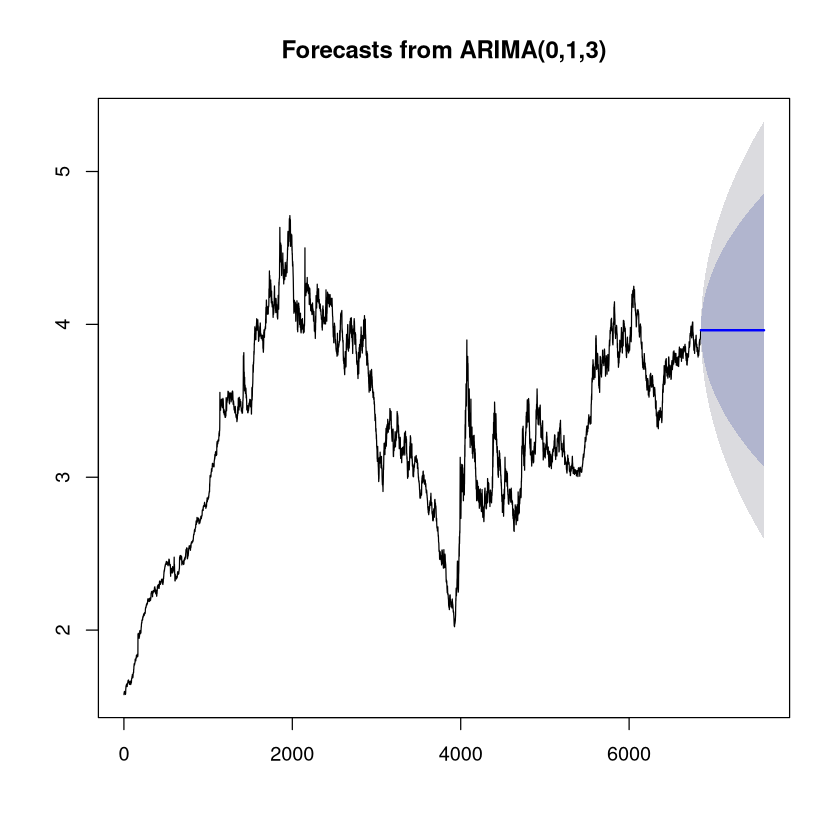

In [237]:
plot(usd_synopsis)